<a href="https://colab.research.google.com/github/zhestyatsky/mipt-opt-project/blob/dev/src/racing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/zhestyatsky/mipt-opt-project.git
import sys
sys.path.append('/content/mipt-opt-project/src')

Cloning into 'mipt-opt-project'...
remote: Enumerating objects: 189, done.
remote: Counting objects: 100% (189/189), done.
remote: Compressing objects: 100% (132/132), done.
remote: Total 346 (delta 112), reused 111 (delta 50), pack-reused 157
Receiving objects: 100% (346/346), 3.97 MiB | 38.02 MiB/s, done.
Resolving deltas: 100% (151/151), done.


In [0]:
import copy
import matplotlib.pyplot as plt

import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import utils
from spider_boost import spider_boost
from natasha import natasha_15, natasha_2

In [3]:
train_dataset = dsets.MNIST(root='~/.pytorch/MNIST_data/', train=True, transform=transforms.ToTensor(), download=True)
train_dataset = utils.DatasetWrapper(train_dataset)

Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [0]:
class CustomModel(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(CustomModel, self).__init__()
        self.conv1 = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        outputs = torch.sigmoid(self.conv1(x))
        return outputs

In [0]:
loss = torch.nn.CrossEntropyLoss()
regularizer = utils.regularizer

In [0]:
batch_size = 6000
learning_rate = 0.001
learning_rate_adagrad = 0.001
learning_rate_decay = 0.001
n_epochs = 200

In [0]:
gd_model = CustomModel(784, 10)
gd_mom_model = copy.deepcopy(gd_model)
adagrad_model = copy.deepcopy(gd_model)
adam_model = copy.deepcopy(gd_model)

sb_model = copy.deepcopy(gd_model)

n15_model = copy.deepcopy(gd_model)
n2_model = copy.deepcopy(gd_model)

if torch.cuda.is_available():
    gd_model = gd_model.cuda()
    gd_mom_model = gd_mom_model.cuda()
    adagrad_model = adagrad_model.cuda()
    adam_model = adam_model.cuda()
    
    sb_model = sb_model.cuda()
    
    n15_model = n15_model.cuda()
    n2_model = n2_model.cuda()

In [0]:
gd_opt = torch.optim.SGD(gd_model.parameters(), lr=learning_rate)
gd_mom_opt = torch.optim.SGD(gd_mom_model.parameters(), lr=learning_rate, momentum=0.9)
adagrad_opt = torch.optim.Adagrad(adagrad_model.parameters(), lr=learning_rate_adagrad, lr_decay=learning_rate_decay)
adam_opt = torch.optim.Adam(adam_model.parameters(), lr=learning_rate)

In [9]:
%%time
gd_total_loss = utils.opt_algorithm(gd_opt, train_dataset, batch_size, gd_model, loss, regularizer, n_epochs)

CPU times: user 1min 34s, sys: 1.26 s, total: 1min 35s
Wall time: 1min 35s


In [10]:
%%time
gd_mom_total_loss = utils.opt_algorithm(gd_mom_opt, train_dataset, batch_size, gd_mom_model, loss, regularizer, n_epochs)

CPU times: user 1min 34s, sys: 1.3 s, total: 1min 36s
Wall time: 1min 36s


In [24]:
%%time
adagrad_total_loss = utils.opt_algorithm(adagrad_opt, train_dataset, batch_size, adagrad_model, loss, regularizer, n_epochs)

CPU times: user 1min 39s, sys: 1.08 s, total: 1min 40s
Wall time: 1min 40s


In [12]:
%%time
adam_total_loss = utils.opt_algorithm(adam_opt, train_dataset, batch_size, adam_model, loss, regularizer, n_epochs)

CPU times: user 1min 35s, sys: 1.01 s, total: 1min 36s
Wall time: 1min 36s


In [13]:
%%time
sb_total_loss = spider_boost(train_dataset, batch_size, sb_model, loss, regularizer, learning_rate, n_epochs)

CPU times: user 1min 35s, sys: 859 ms, total: 1min 36s
Wall time: 1min 36s


In [0]:
#%%time
#n_15_total_loss = natasha_15(train_dataset, batch_size, n15_model, loss, regularizer, learning_rate, n_epochs, sigma=10)

In [0]:
#%%time
#n_2_total_loss = natasha_2(train_dataset, batch_size, n2_model, loss, regularizer, learning_rate, n_epochs)

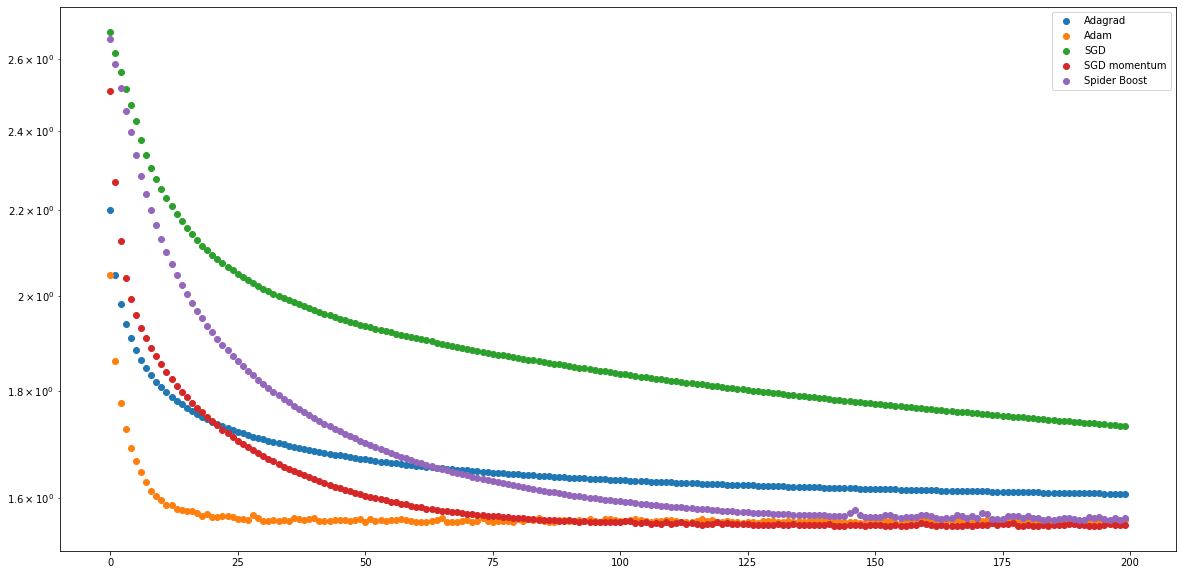

In [25]:
plt.figure(figsize=(20,10))
plt.plot(adagrad_total_loss, 'o', label='Adagrad')
plt.plot(adam_total_loss, 'o', label='Adam')
plt.plot(gd_total_loss, 'o', label='SGD')
plt.plot(gd_mom_total_loss, 'o', label='SGD momentum')
#plt.plot(n_15_total_loss, 'o', label='Natasha 1.5')
#plt.plot(n_2_total_loss, 'o', label='Natasha 2')
plt.plot(sb_total_loss, 'o', label='Spider Boost')
plt.legend()
plt.semilogy()
plt.show()